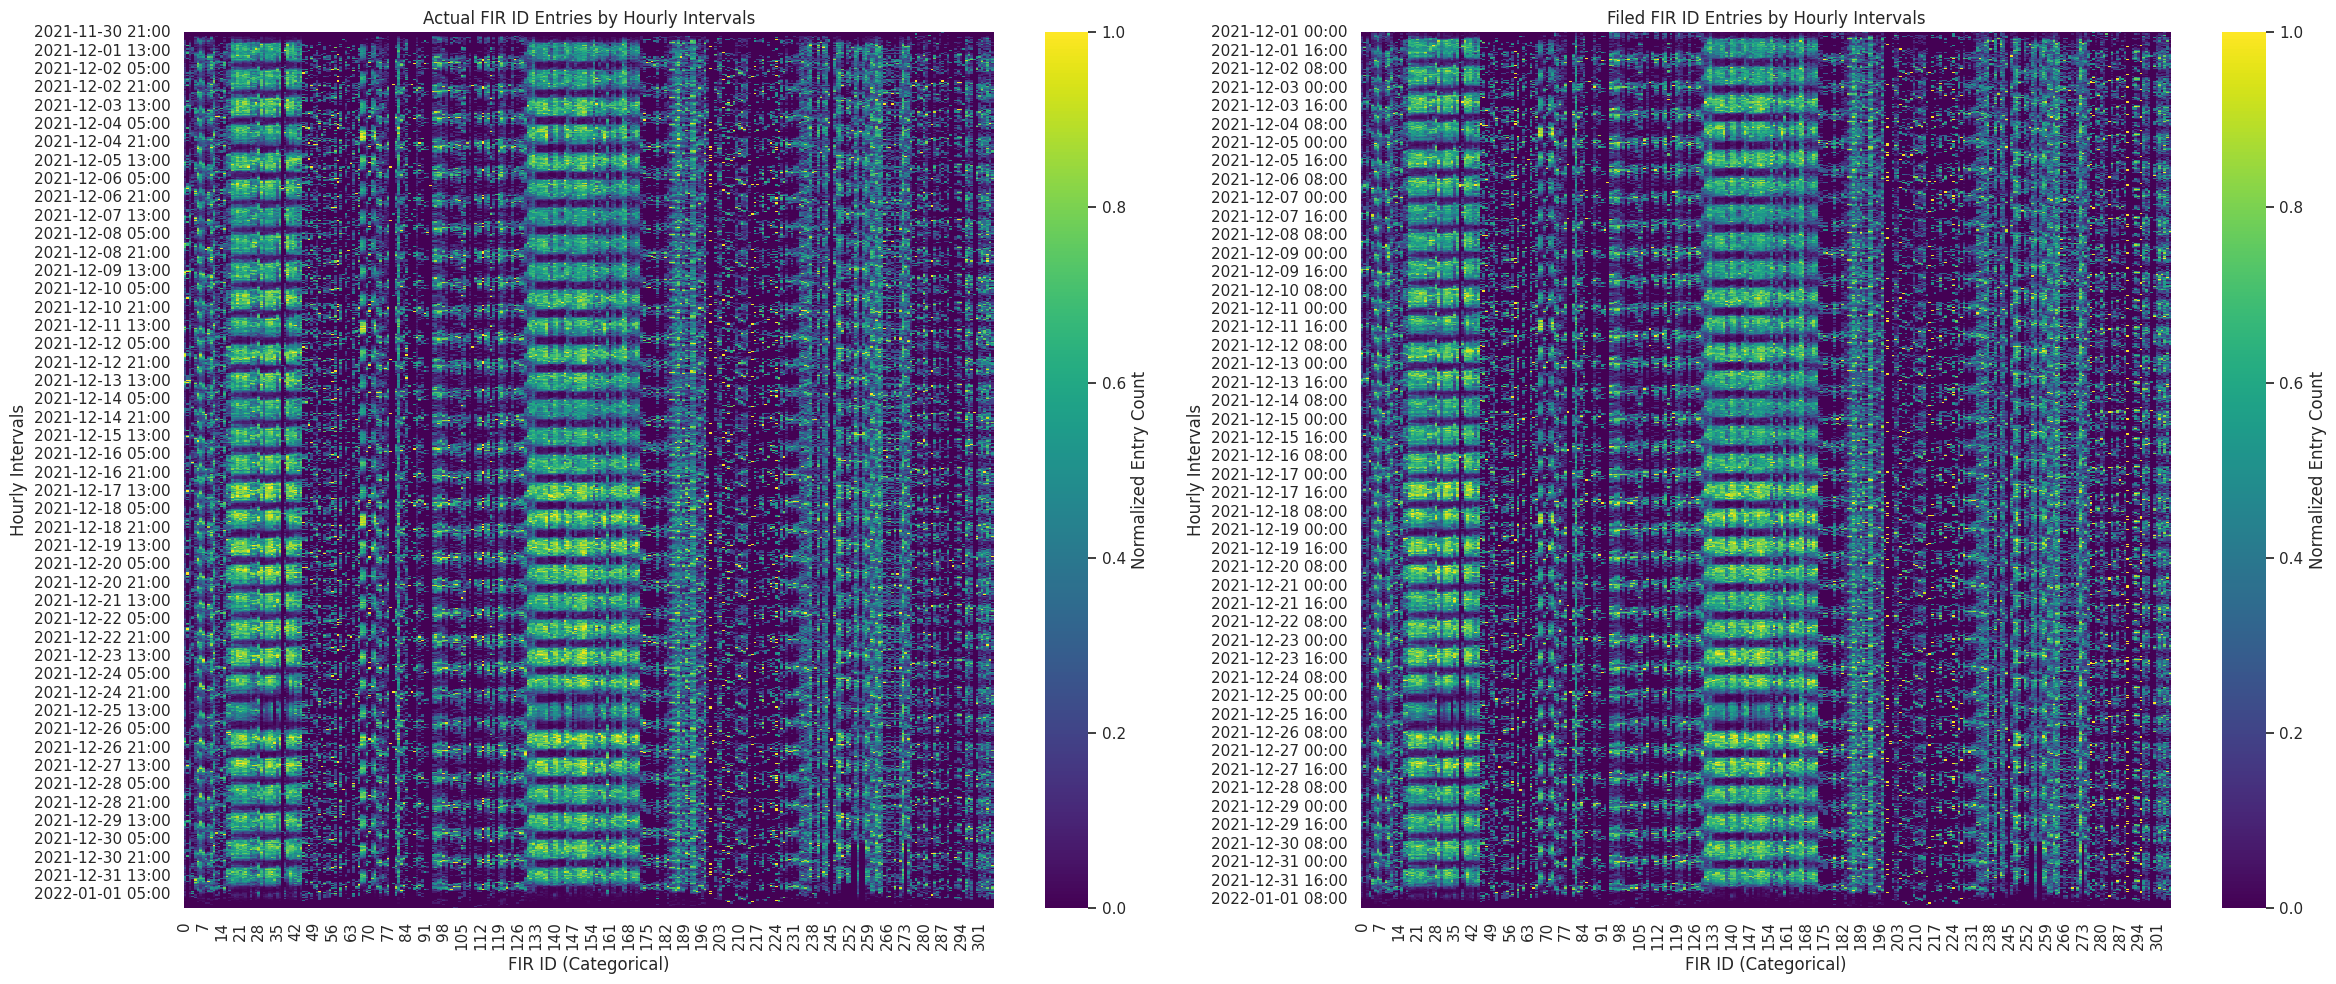

In [1]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


file_actual_firs = './Eurocontrol_data/202112/Flight_FIRs_Actual_20211201_20211231.csv'
file_filed_firs = './Eurocontrol_data/202112/Flight_FIRs_Filed_20211201_20211231.csv'

actual_firs_df = pd.read_csv(file_actual_firs)
filed_firs_df = pd.read_csv(file_filed_firs)


actual_firs_df['Entry Time'] = pd.to_datetime(actual_firs_df['Entry Time'], format='%d-%m-%Y %H:%M:%S')
actual_firs_df['Exit Time'] = pd.to_datetime(actual_firs_df['Exit Time'], format='%d-%m-%Y %H:%M:%S')

filed_firs_df['Entry Time'] = pd.to_datetime(filed_firs_df['Entry Time'], format='%d-%m-%Y %H:%M:%S')
filed_firs_df['Exit Time'] = pd.to_datetime(filed_firs_df['Exit Time'], format='%d-%m-%Y %H:%M:%S')


actual_firs_df = actual_firs_df[~actual_firs_df['FIR ID'].str.contains('TAXI_IN|TAXI_OUT')]
filed_firs_df = filed_firs_df[~filed_firs_df['FIR ID'].str.contains('TAXI_IN|TAXI_OUT')]


actual_firs_df['Hourly Intervals'] = actual_firs_df['Entry Time'].dt.floor('H')
filed_firs_df['Hourly Intervals'] = filed_firs_df['Entry Time'].dt.floor('H')

# convert the FIR ID to a categorical variable
actual_firs_df['FIR ID'] = pd.Categorical(actual_firs_df['FIR ID']).codes
filed_firs_df['FIR ID'] = pd.Categorical(filed_firs_df['FIR ID']).codes


# Pivot table to transform data for the heatmap
actual_firs_pivot_table = actual_firs_df.pivot_table(index='Hourly Intervals', columns='FIR ID', aggfunc='size', fill_value=0)
filed_firs_pivot_table = filed_firs_df.pivot_table(index='Hourly Intervals', columns='FIR ID', aggfunc='size', fill_value=0)

# convert the format of the index from (e.g. 2021-01-12 00:00:00 to 2021-01-12 00:00)
actual_firs_pivot_table.index = actual_firs_pivot_table.index.strftime('%Y-%m-%d %H:%M')
filed_firs_pivot_table.index = filed_firs_pivot_table.index.strftime('%Y-%m-%d %H:%M')

# Normalize the values for better visualization
actual_firs_normalized_table = (actual_firs_pivot_table - actual_firs_pivot_table.min()) / (actual_firs_pivot_table.max() - actual_firs_pivot_table.min())
filed_firs_normalized_table = (filed_firs_pivot_table - filed_firs_pivot_table.min()) / (filed_firs_pivot_table.max() - filed_firs_pivot_table.min())
# normalized_table = pivot_table / pivot_table.max()

# Setup for subplots
plt.figure(figsize=(24, 10))  # Increased figure size for clarity
sns.set_theme()

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
ax1 = sns.heatmap(actual_firs_normalized_table, cmap="viridis", cbar_kws={'label': 'Normalized Entry Count'})
ax1.set_title('Actual FIR ID Entries by Hourly Intervals')
ax1.set_xlabel('FIR ID (Categorical)')
ax1.set_ylabel('Hourly Intervals')

# Second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
ax2 = sns.heatmap(filed_firs_normalized_table, cmap="viridis", cbar_kws={'label': 'Normalized Entry Count'})
ax2.set_title('Filed FIR ID Entries by Hourly Intervals')
ax2.set_xlabel('FIR ID (Categorical)')
ax2.set_ylabel('Hourly Intervals')

# Improve layout to fit the labels and show the plot
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
# Save the plot
plt.savefig('firs_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


### Including Airports

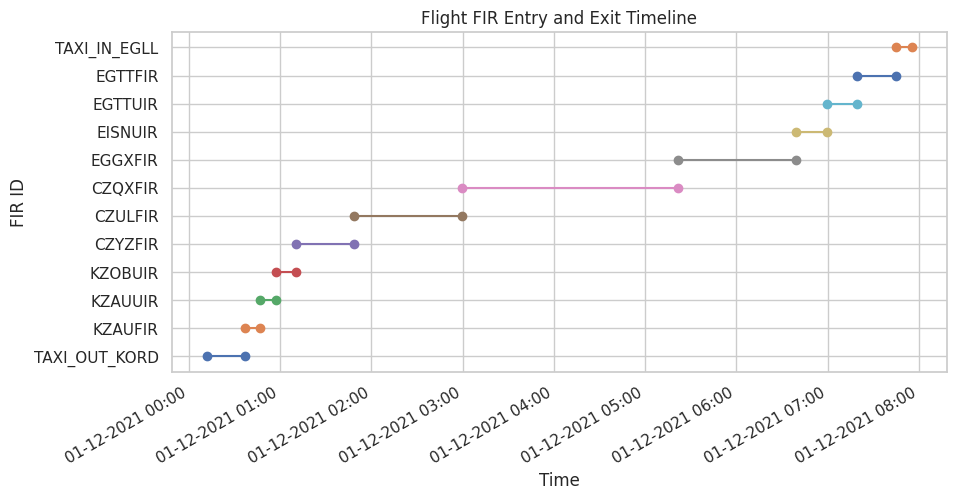

In [2]:
file_actual_firs = './Eurocontrol_data/202112/Flight_FIRs_Actual_20211201_20211231.csv'
file_filed_firs = './Eurocontrol_data/202112/Flight_FIRs_Filed_20211201_20211231.csv'
file_flights = './Eurocontrol_data/202112/Flights_20211201_20211231.csv'
actual_firs_df = pd.read_csv(file_actual_firs)
filed_firs_df = pd.read_csv(file_filed_firs)
flights_df = pd.read_csv(file_flights)

actual_firs_df['Entry Time'] = pd.to_datetime(actual_firs_df['Entry Time'], format='%d-%m-%Y %H:%M:%S')
actual_firs_df['Exit Time'] = pd.to_datetime(actual_firs_df['Exit Time'], format='%d-%m-%Y %H:%M:%S')
filed_firs_df['Entry Time'] = pd.to_datetime(filed_firs_df['Entry Time'], format='%d-%m-%Y %H:%M:%S')
filed_firs_df['Exit Time'] = pd.to_datetime(filed_firs_df['Exit Time'], format='%d-%m-%Y %H:%M:%S')


# merge actual_firs_df with flights_df, used "ECTRL ID" as the key to merge, merge only the columns from flights_df: ADES adn ADEP
actual_firs_df = pd.merge(actual_firs_df, flights_df[['ECTRL ID', 'ADES', 'ADEP']], on='ECTRL ID', how='left')

# append the the ADEP to the "FIR ID" columen if the "FIR ID" is "TAXI_OUT"
actual_firs_df['FIR ID'] = actual_firs_df.apply(lambda x: x['FIR ID'] + '_' + x['ADEP'] if x['FIR ID'] == 'TAXI_OUT' else x['FIR ID'], axis=1)

# append the the ADES to the "FIR ID" columen if the "FIR ID" is "TAXI_IN"
actual_firs_df['FIR ID'] = actual_firs_df.apply(lambda x: x['FIR ID'] + '_' + x['ADES'] if x['FIR ID'] == 'TAXI_IN' else x['FIR ID'], axis=1)

# drop the ADES and ADEP columns
actual_firs_df.drop(columns=['ADES', 'ADEP'], inplace=True)

# repeat the same steps for the filed_firs_df
filed_firs_df = pd.merge(filed_firs_df, flights_df[['ECTRL ID', 'ADES', 'ADEP']], on='ECTRL ID', how='left')
filed_firs_df['FIR ID'] = filed_firs_df.apply(lambda x: x['FIR ID'] + '_' + x['ADEP'] if x['FIR ID'] == 'TAXI_OUT' else x['FIR ID'], axis=1)
filed_firs_df['FIR ID'] = filed_firs_df.apply(lambda x: x['FIR ID'] + '_' + x['ADES'] if x['FIR ID'] == 'TAXI_IN' else x['FIR ID'], axis=1)
filed_firs_df.drop(columns=['ADES', 'ADEP'], inplace=True)


flight_id =  actual_firs_df['ECTRL ID'].unique()[0]
sample_flight = actual_firs_df[actual_firs_df['ECTRL ID'] == flight_id]

# sns whight background
sns.set_theme()
sns.set_style("whitegrid")

# Plot the FIR entry and exit timeline
plt.figure(figsize=(10, 5))
for _, row in sample_flight.iterrows():
    plt.plot([row['Entry Time'], row['Exit Time']], [row['FIR ID'], row['FIR ID']], marker = 'o')

# Formatting the plot
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=1))
plt.gcf().autofmt_xdate()  # Rotate date labels

plt.title('Flight FIR Entry and Exit Timeline')
plt.xlabel('Time')
plt.ylabel('FIR ID')
plt.grid(True)
plt.show()

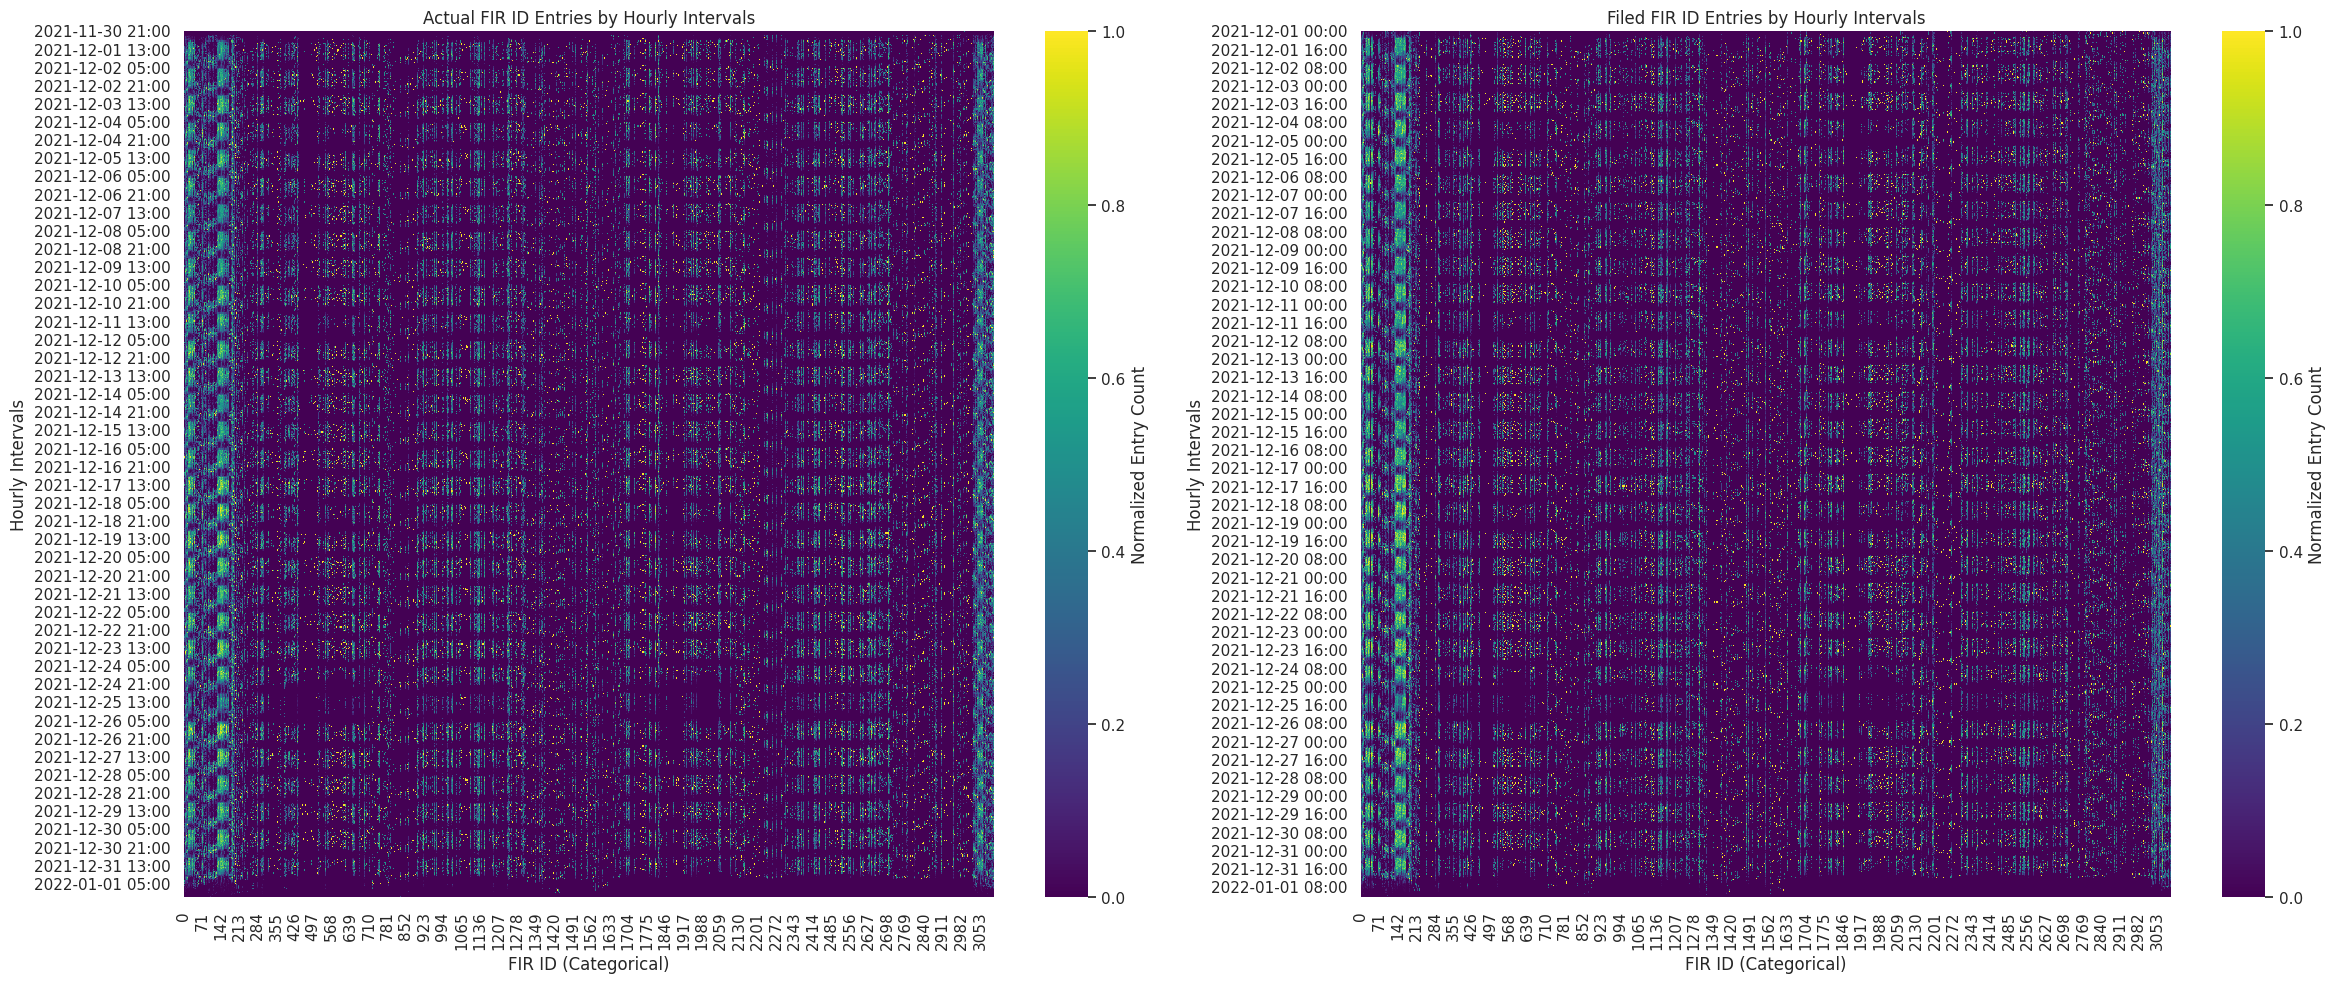

In [3]:

actual_firs_df['Hourly Intervals'] = actual_firs_df['Entry Time'].dt.floor('H')
filed_firs_df['Hourly Intervals'] = filed_firs_df['Entry Time'].dt.floor('H')

# convert the FIR ID to a categorical variable
actual_firs_df['FIR ID'] = pd.Categorical(actual_firs_df['FIR ID']).codes
filed_firs_df['FIR ID'] = pd.Categorical(filed_firs_df['FIR ID']).codes


# Pivot table to transform data for the heatmap
actual_firs_pivot_table = actual_firs_df.pivot_table(index='Hourly Intervals', columns='FIR ID', aggfunc='size', fill_value=0)
filed_firs_pivot_table = filed_firs_df.pivot_table(index='Hourly Intervals', columns='FIR ID', aggfunc='size', fill_value=0)

# convert the format of the index from (e.g. 2021-01-12 00:00:00 to 2021-01-12 00:00)
actual_firs_pivot_table.index = actual_firs_pivot_table.index.strftime('%Y-%m-%d %H:%M')
filed_firs_pivot_table.index = filed_firs_pivot_table.index.strftime('%Y-%m-%d %H:%M')

# Normalize the values for better visualization
actual_firs_normalized_table = (actual_firs_pivot_table - actual_firs_pivot_table.min()) / (actual_firs_pivot_table.max() - actual_firs_pivot_table.min())
filed_firs_normalized_table = (filed_firs_pivot_table - filed_firs_pivot_table.min()) / (filed_firs_pivot_table.max() - filed_firs_pivot_table.min())
# normalized_table = pivot_table / pivot_table.max()

# Setup for subplots
plt.figure(figsize=(24, 10))  # Increased figure size for clarity
sns.set_theme()

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
ax1 = sns.heatmap(actual_firs_normalized_table, cmap="viridis", cbar_kws={'label': 'Normalized Entry Count'})
ax1.set_title('Actual FIR ID Entries by Hourly Intervals')
ax1.set_xlabel('FIR ID (Categorical)')
ax1.set_ylabel('Hourly Intervals')

# Second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
ax2 = sns.heatmap(filed_firs_normalized_table, cmap="viridis", cbar_kws={'label': 'Normalized Entry Count'})
ax2.set_title('Filed FIR ID Entries by Hourly Intervals')
ax2.set_xlabel('FIR ID (Categorical)')
ax2.set_ylabel('Hourly Intervals')

# Improve layout to fit the labels and show the plot
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
# Save the plot
plt.savefig('firs_heatmap_with_airports.png', dpi=300, bbox_inches='tight')
plt.show()
